# Fase 1: Clasificación del movimiento

**Descripción**\
Copia de Fase1

**Entrada**
* ``medidasPerRepetition.csv``: archivo en formato CSV que contiene cálculos estadísticos sobre los ángulos por repetición de cada sujeto. Este es el archivo de salida de *leer_dataset.ipynb*.

**Salida**
* ``modelo_fase1_copy.sav``: archivo que guarda el pipeline completo de clasificación entrenado

******

In [1]:
# ---------- Importar librerías---------
# Manipular los datos
import pandas as pd
import numpy as np

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

# Scikit-learn (ML en python)
## Modelos ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
## Evaluación de los modelos
from sklearn.metrics import *
from sklearn.model_selection import LearningCurveDisplay
## Hiperparametrizacion
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import LeaveOneGroupOut
## Seleccion de variables
from sklearn.feature_selection import SelectKBest

#Pipeline
from imblearn.pipeline import Pipeline

# Guardar modelos
import joblib

# Para ignorar los FutureWarning
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
#---------Importar los datos-----------
# Dataframe medidas calculadas por repetición
df = pd.read_csv('../Resultados/medidasPerRepetition.csv', dtype=object) # salida de leer_dataset.ipynb
df.drop(['CorrectLabel'], axis=1,
             inplace=True)
df.head() # visualizacion de la cabecera

,SubjectID,GestureLabel,GestureName,RepetitionNumber,Duration,WristAngleLeft_standardDeviation,AnkleAngleRight_standardDeviation,ElbowAngleRight_standardDeviation,HipAngleRight_standardDeviation,ShoulderAngleLeft_standardDeviation,...,ShoulderAngleLeft_Kurtosis,ShoulderAngleRight_Kurtosis,RightArmAngle_Kurtosis,KneeAngleLeft_Kurtosis,KneeAngleRight_Kurtosis,ArmsTogetherAngle_Kurtosis,AnkleAngleLeft_Kurtosis,WristAngleRight_Kurtosis,HipAngleLeft_Kurtosis,LeftArmAngle_Kurtosis
0,102,0,EFL,1,74,1.3775399963780737,1.7357630825345078,53.294387123124494,0.3063581511814836,0.43337687198692865,...,-1.2511436779592484,-0.005024522767072437,0.22147301566722177,-0.16696522726578022,-0.15931125809206037,-0.8511018898740983,-0.9218459378889565,0.375606810920206,0.1950860066202451,-0.9889825587727601
1,102,0,EFL,2,64,1.6271894060456007,2.5199308063586257,49.40877427754448,0.2752282296825027,0.202969587825486,...,-0.472467253988782,-0.6576579439512305,-1.4860333958071466,-1.05513197100136,-0.7952358950848302,-1.4196823310401139,-1.415922318356331,1.1543998957163382,-0.7888113108681654,-1.2938450639789785
2,102,0,EFL,3,58,1.6989747606490668,0.8997987242880856,47.97213470442852,0.2968562465955533,0.20525413209570925,...,-0.80871088359656,-0.564910069837087,-0.7913285454951731,-1.142127903113062,-0.6294624577289896,-1.5629680711446194,-1.2031165908034858,9.59080204890984,-0.9158241443474404,-1.2447151128330012
3,102,0,EFL,4,60,2.016339624917005,1.140918640565108,49.08240144573414,0.2897218836846879,0.24336914642004395,...,-1.177012012109949,0.12170810583775316,0.2021513530164274,-1.2227381742521826,-0.8623099615734113,-1.6903677661810008,-1.515334441103624,4.1336237058292,-1.1852260550732128,-1.5331879897259844
4,102,0,EFL,5,63,1.7008586220937247,1.9153757520588566,49.404534166582316,0.18288000709507443,0.2335806190663636,...,-0.6891877979451944,0.2395354931475424,0.8374033797172151,0.01031777600595607,-0.7211398634607731,-1.7197444051478152,-0.5172894066010225,5.640903309376775,-0.5924323757251706,-1.2588672287903098


****

## 1. Preprocesado

**1.1 Codificar variables**

In [3]:
# ------Preparar el dataset-------
df = df.drop(['GestureName'], axis=1)

# pasar variable obj to numeric
df = df.apply(pd.to_numeric, errors='ignore')
df.head()

,SubjectID,GestureLabel,RepetitionNumber,Duration,WristAngleLeft_standardDeviation,AnkleAngleRight_standardDeviation,ElbowAngleRight_standardDeviation,HipAngleRight_standardDeviation,ShoulderAngleLeft_standardDeviation,ShoulderAngleRight_standardDeviation,...,ShoulderAngleLeft_Kurtosis,ShoulderAngleRight_Kurtosis,RightArmAngle_Kurtosis,KneeAngleLeft_Kurtosis,KneeAngleRight_Kurtosis,ArmsTogetherAngle_Kurtosis,AnkleAngleLeft_Kurtosis,WristAngleRight_Kurtosis,HipAngleLeft_Kurtosis,LeftArmAngle_Kurtosis
0,102,0,1,74,1.377540,1.735763,53.294387,0.306358,0.433377,3.294714,...,-1.251144,-0.005025,0.221473,-0.166965,-0.159311,-0.851102,-0.921846,0.375607,0.195086,-0.988983
1,102,0,2,64,1.627189,2.519931,49.408774,0.275228,0.202970,4.742960,...,-0.472467,-0.657658,-1.486033,-1.055132,-0.795236,-1.419682,-1.415922,1.154400,-0.788811,-1.293845
2,102,0,3,58,1.698975,0.899799,47.972135,0.296856,0.205254,5.070928,...,-0.808711,-0.564910,-0.791329,-1.142128,-0.629462,-1.562968,-1.203117,9.590802,-0.915824,-1.244715
3,102,0,4,60,2.016340,1.140919,49.082401,0.289722,0.243369,4.030705,...,-1.177012,0.121708,0.202151,-1.222738,-0.862310,-1.690368,-1.515334,4.133624,-1.185226,-1.533188
4,102,0,5,63,1.700859,1.915376,49.404534,0.182880,0.233581,5.021403,...,-0.689188,0.239535,0.837403,0.010318,-0.721140,-1.719744,-0.517289,5.640903,-0.592432,-1.258867


**1.2 Dividir el dataset**

In [4]:
# ---- Dividir en test y train -----------
# Selecciona los datos de prueba (varios sujetos)
test_df = df.loc[(df.SubjectID==102) | (df.SubjectID==105) | (df.SubjectID==201) |
            (df.SubjectID==202) | (df.SubjectID==205) | (df.SubjectID==302)] 

# Selecciona los datos de entrenamiento excluyendo los mismos sujetos
train_df = df.loc[(df.SubjectID!=102) & (df.SubjectID!=105)  & (df.SubjectID!=201) &
                (df.SubjectID!=202) & (df.SubjectID!=205) & (df.SubjectID!=302)]

# Caclular porcentajes
n_total = len(df)
print(f'Entrenamiento {(len(train_df)*100)/n_total}%. Prueba {(len(test_df)*100)/n_total}%')

# ------- Dividir en target y variables ---------
train_X = train_df.drop(['GestureLabel'], axis=1)
train_y=pd.DataFrame(train_df['GestureLabel']) 
test_X= test_df.drop(['GestureLabel'], axis=1) 
test_y =pd.DataFrame(test_df['GestureLabel'])

# Convertimos los df de target (y) a 1-d
train_y = train_y.values.ravel()
test_y = test_y.values.ravel()

Entrenamiento 76.71232876712328%. Prueba 23.28767123287671%


*****

## 2. Pipeline

**2.1 Malla de hiperparámetros**

In [5]:
#------------- Malla de hiperparametros ---------------
param_grid = [
    {
        'feature_selection__k': list(range(35, 60)),
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [6, 7, 8],
        'classifier__weights': ('uniform', 'distance'),
        'classifier__leaf_size': (3, 4, 5, 6, 8),
        'classifier__p': (1,2),
        'classifier__metric': ('minkowski', 'chebyshev')
    },
    {
        'feature_selection__k': list(range(35, 60)),
        'classifier': [DecisionTreeClassifier()],
        'classifier__criterion': ['gini', 'entropy', 'log_loss'],
        'classifier__splitter': ['best', 'random'],
        'classifier__max_depth': [None, 40, 50, 60],
        'classifier__min_samples_split': [2, 10, 20],
        'classifier__min_samples_leaf': [1, 2, 5, 7],
        'classifier__max_features': [None, 'sqrt', 'log2']
    },
    {
        'feature_selection__k': list(range(35, 60)),
        'classifier': [GaussianNB()],
        'classifier__var_smoothing': np.logspace(0, -8, num=100)
    },
    {
        'feature_selection__k': list(range(35, 60)),
        'classifier': [SVC()],
        'classifier__C': [0.1, 0.2, 0.3],
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'classifier__gamma': ['scale', 'auto'],
        'classifier__degree': [2, 3],
        'classifier__coef0': [0.0, 0.1, 0.2]
    },
    {
        'feature_selection__k': list(range(35, 60)),
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [300, 400, 500],
        'classifier__max_features': ['sqrt', 'log2'],
        'classifier__max_depth': [None, 50, 60],
        'classifier__min_samples_split': [2, 3, 4],
        'classifier__min_samples_leaf': [1, 2, 5, 6],
    },
    {
        
        'feature_selection__k': list(range(35, 60)),
        'classifier': [MLPClassifier()],
        'classifier__hidden_layer_sizes': [(50, 50, 50), (50, 100, 50)], 
        'classifier__activation': ['relu', 'tanh', 'logistic'],
        'classifier__solver': ['sgd', 'adam'],
        'classifier__alpha': [0.0001, 0.001, 0.01, 0.05, 0.1],
        'classifier__learning_rate': ['constant', 'invscaling', 'adaptive']
    }
]

**2.2 Pipeline e hiperparametrización**

In [6]:
logo = LeaveOneGroupOut()
subject_ids = train_X['SubjectID'] # para los grupos
pipeline = Pipeline([
                     ('feature_selection', SelectKBest(k=50)),
                     ('classifier', KNeighborsClassifier(n_neighbors=2))
                    ])
random = RandomizedSearchCV(pipeline, param_grid, cv=logo, n_jobs=-1, n_iter=15,
                            scoring='f1_weighted', random_state=42)
random.fit(train_X, train_y, groups=subject_ids)

best_modelo = random.best_estimator_
print(best_modelo)

Pipeline(steps=[('feature_selection', SelectKBest(k=58)),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=60,
                                        min_samples_leaf=5,
                                        min_samples_split=20))])


**2.3 Evaluación del pipeline**

In [7]:
f1_score_train = best_modelo.score(train_X, train_y)
print(f'F1-score del conjunto de entrenamiento: {f1_score_train}')
print("Informe de clasificación (conjunto de prueba):")
prediction = best_modelo.predict(test_X)
print(classification_report(test_y, prediction)) 

F1-score del conjunto de entrenamiento: 0.9527310924369747
Informe de clasificación (conjunto de prueba):
              precision    recall  f1-score   support

           0       0.70      0.83      0.76        52
           1       0.93      0.79      0.85        70
           2       0.70      0.87      0.78        84
           3       0.63      0.82      0.71        57
           4       0.83      0.59      0.69        83
           5       0.90      0.86      0.88        43
           6       0.91      0.85      0.88        46
           7       0.54      0.72      0.62        60
           8       0.72      0.49      0.59        83

    accuracy                           0.74       578
   macro avg       0.76      0.76      0.75       578
weighted avg       0.76      0.74      0.74       578



* **Curva de apendizaje**

<Figure size 600x400 with 0 Axes>

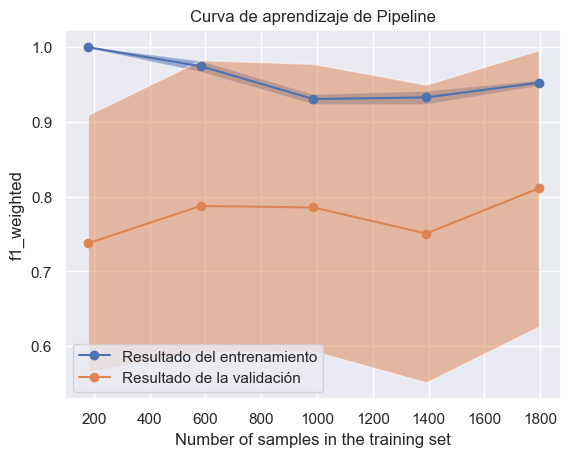

In [8]:
plt.figure(figsize=(6,4))
LearningCurveDisplay.from_estimator(best_modelo, 
                                    X=train_X,
                                    y=train_y,
                                    groups=subject_ids,
                                    cv=logo,
                                    score_type="both",
                                    n_jobs=4,
                                    line_kw={"marker": "o"},
                                    std_display_style="fill_between",
                                    score_name="f1_weighted"
                                )
    
plt.legend(["Resultado del entrenamiento", "Resultado de la validación"])
plt.title(f"Curva de aprendizaje de {random.estimator.__class__.__name__}")
plt.show()

* **Matriz de confusión**

Text(47.25, 0.5, 'True labels')

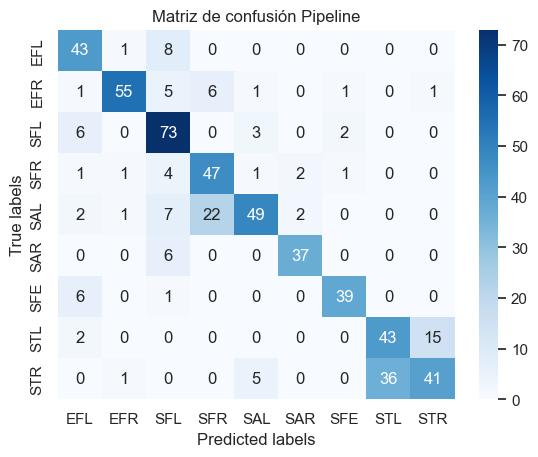

In [9]:
cm = confusion_matrix(test_y, prediction)
cm_df = pd.DataFrame(cm,
                    index = ['EFL','EFR','SFL', 'SFR', 'SAL',
                            'SAR', 'SFE', 'STL', 'STR'], 
                    columns = ['EFL','EFR','SFL', 'SFR', 'SAL',
                            'SAR', 'SFE', 'STL', 'STR'])
ax = sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d")
ax.set_title(f'Matriz de confusión {best_modelo.__class__.__name__}')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

**2.3 Guardar el pipeline**

In [10]:
# ------ Guardar el pipeline entrenado --------
filename = '../Resultados/modelo_fase1_copy.sav'
joblib.dump(best_modelo, filename)

['../Resultados/modelo_fase1_copy.sav']